In [84]:
# EDA Libraries:  
  
import pandas as pd  
import numpy as np 

import matplotlib.colors as col  
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt  
import seaborn as sns  
%matplotlib inline  

  
# Scikit-Learn models:  
  
from sklearn.preprocessing import MinMaxScaler  
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  
from sklearn.ensemble import RandomForestRegressor  
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split  

import warnings  

In [2]:
#create a function that will be used for the extraction of a CSV file and then converting it to pandas dataframe
def load_data(file_name):  
    """Returns a pandas dataframe from a csv file."""  
    return pd.read_csv(file_name)  

In [5]:
train_df = load_data('train.csv')
test_df = load_data('test.csv')
syb_df = load_data('sample_submission.csv')

<Axes: >

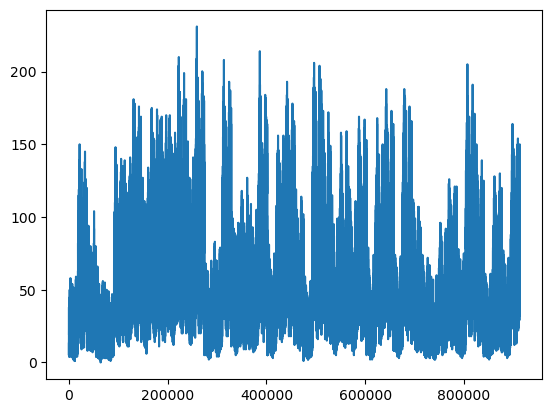

In [6]:
# To view basic statistical details about dataset:  
  
train_df['sales'].describe()  
  
train_df['sales'].plot()  

In [7]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [13]:
def sales_period(data):  
    """Time interval of train dataset:"""  
  
    print(f'time period starts from :{data["date"].min()}, and ends in :{data["date"].max()}')
sales_period(train_df)

time period starts from :2013-01-01, and ends in :2017-12-31


In [14]:
sales_period(test_df)

time period starts from :2018-01-01, and ends in :2018-03-31


In [15]:
train_df.shape, test_df.shape

((913000, 4), (45000, 4))

In [36]:
def sales_per_store(data):
    
    sales_by_store = data.groupby('store')['sales'].sum().reset_index() 
    fig, ax = plt.subplots(figsize=(8,6)) 
    sns.barplot(sales_by_store, x="store", y="sales", estimator="sum", errorbar=None)
    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")   
     
    return sales_by_store, ax

(   store    sales
 0      1  4315603
 1      2  6120128
 2      3  5435144
 3      4  5012639
 4      5  3631016
 5      6  3627670
 6      7  3320009
 7      8  5856169
 8      9  5025976
 9     10  5360158,
 <Axes: title={'center': 'Total Sales Per Store'}, xlabel='Store Id', ylabel='Sum of Sales'>)

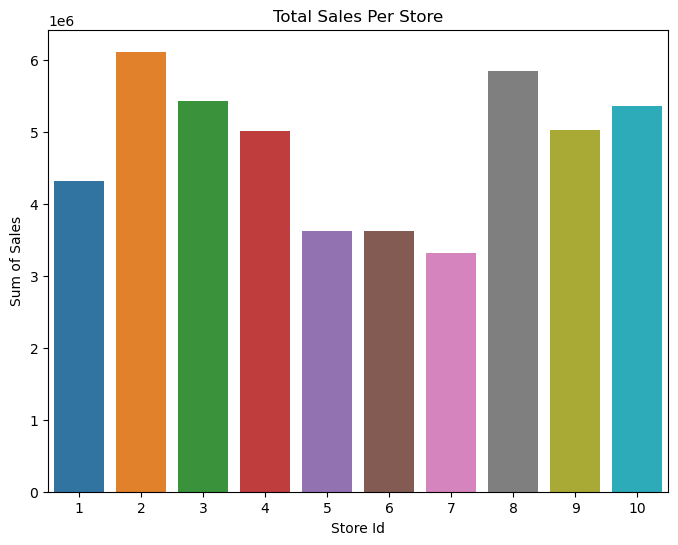

In [37]:
sales_per_store(train_df)
     


In [41]:
def build_sales_diff_data(data):  
    """Generates a CSV file with a datetime index and a dependent sales column for ARIMA modelling."""  
     
    da_data = data.set_index('date').drop('sales', axis=1)  
    da_data.dropna(axis=0)  
    da_data.drop(['store','item'], axis = 1, inplace=True)
     
    da_data.to_csv('./arima_df.csv')  
     
    return da_data  
  
datatime_df = build_sales_diff_data(train_df)  
datatime_df # ARIMA Dataframe  


,sales_diff
date,
2013-01-01,NaN
2013-01-02,-2.0
2013-01-03,3.0
2013-01-04,-1.0
2013-01-05,-3.0
...,...
2017-12-27,22.0
2017-12-28,-4.0
2017-12-29,15.0


In [50]:
def sales_by_dt(data):
    data['date'] = pd.to_datetime(data['date'])
    sales_by_date = data.groupby('date')['sales'].sum().reset_index()

    #display the results
    return sales_by_date

sales_by_date = sales_by_dt(train_df)

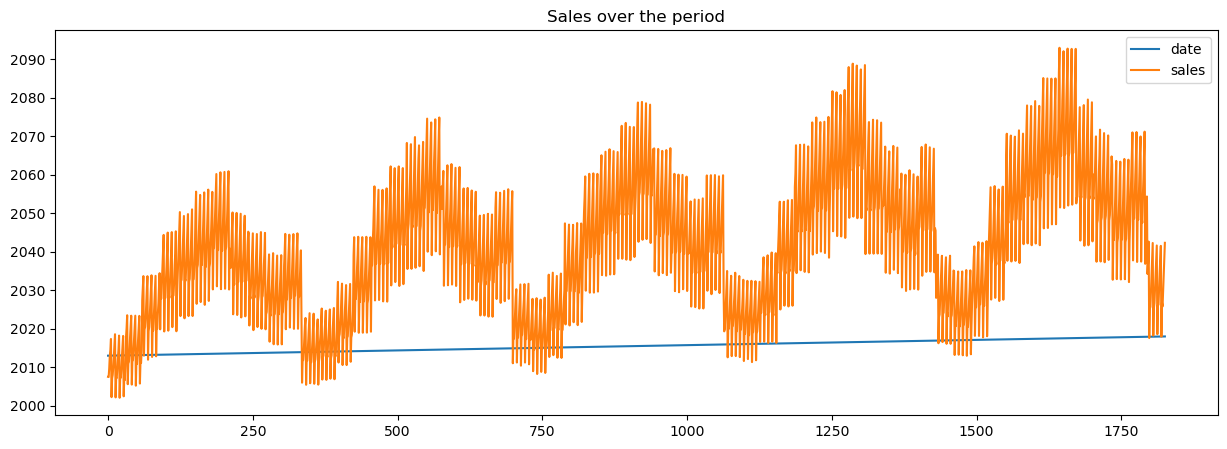

In [52]:
sales_by_date.plot(
        # style='.',
        figsize=(15, 5),
        title='Sales over the period')
plt.show()

In [53]:
store_daily_sales = train_df.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train_df.groupby(['item', 'date'], as_index=False)['sales'].sum()

Text(0, 0.5, 'Sales')

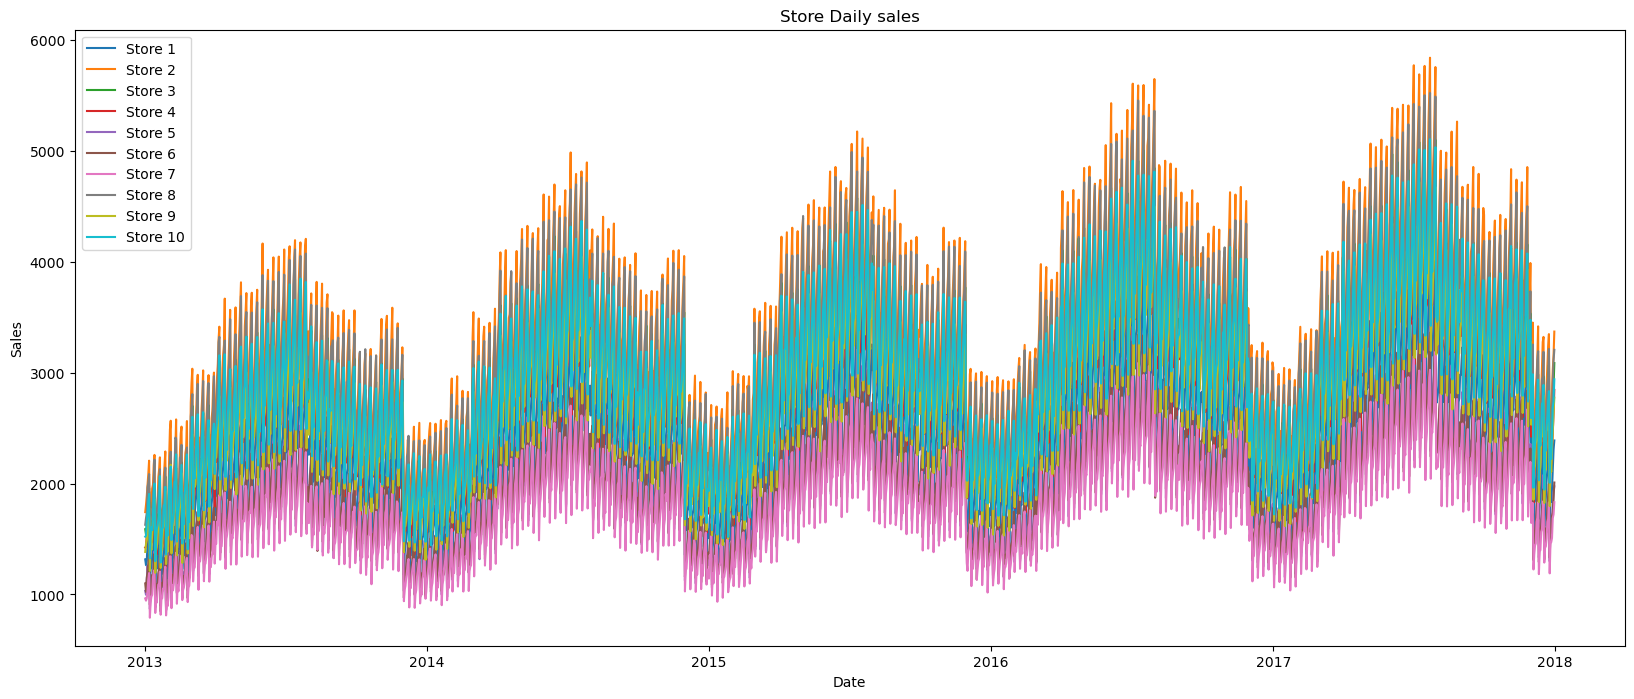

In [54]:
plt.figure(figsize=(20, 8))

for i in range(1, 11):
    temp = store_daily_sales[store_daily_sales.store == i]
    plt.plot(temp['date'], temp['sales'], label='Store %d'%i)
    
plt.legend()
plt.title('Store Daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')

In [55]:
train_df[["store"]].nunique() 

train_df[["item"]].nunique() 

train_df.groupby(["store"])["item"].nunique()

train_df.groupby(["store", "item"]).agg({"sales": ["sum"]})

train_df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
               sum       mean median        std
store item                                     
1     1      36468  19.971522   19.0   6.741022
      2      97050  53.148959   52.0  15.005779
      3      60638  33.208105   33.0  10.072529
      4      36440  19.956188   20.0   6.640618
      5      30335  16.612815   16.0   5.672102
...            ...        ...    ...        ...
10    46    120601  66.046550   65.0  18.114991
      47     45204  24.755750   24.0   7.924820
      48    105570  57.814896   57.0  15.898538
      49     60317  33.032311   32.0  10.091610
      50    135192  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [56]:
# how many unique stores and unique items?

store_count = len(pd.unique(train_df["store"]))
print(f"There are {store_count} stores, and ", end='')

item_count = len(pd.unique(train_df["item"]))
print(f"{item_count} unique items")

There are 10 stores, and 50 unique items


In [57]:
train_dt_sales = train_df.groupby('date').sum('sales')
train_dt_sales.index = pd.to_datetime(train_dt_sales.index)
train_dt_sales = train_dt_sales.drop(['store','item'], axis=1)
train_dt_sales.head()

,sales,sales_diff
date,,
2013-01-01,13696,-12655.0
2013-01-02,13678,-18.0
2013-01-03,14488,810.0
2013-01-04,15677,1189.0
2013-01-05,16237,560.0


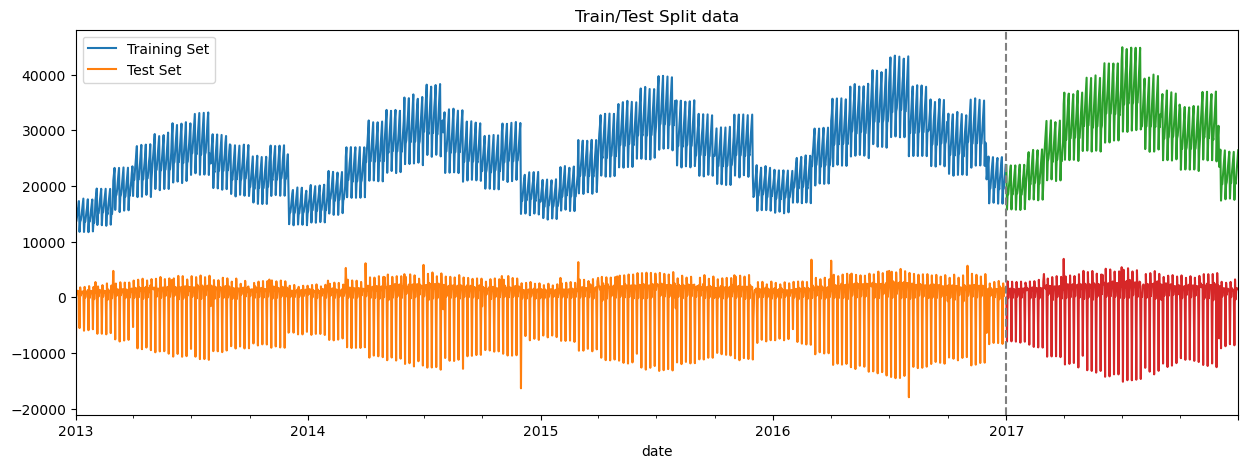

In [58]:
train = train_dt_sales.loc[train_dt_sales.index < '01-01-2017']
test = train_dt_sales.loc[train_dt_sales.index >= '01-01-2017']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split data')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='Gray', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [59]:
def create_features(df):
    """
    Creating time series features based on dataframe index.
    """
    df = df.copy()
    # df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

train_dt_sales = create_features(train_dt_sales)

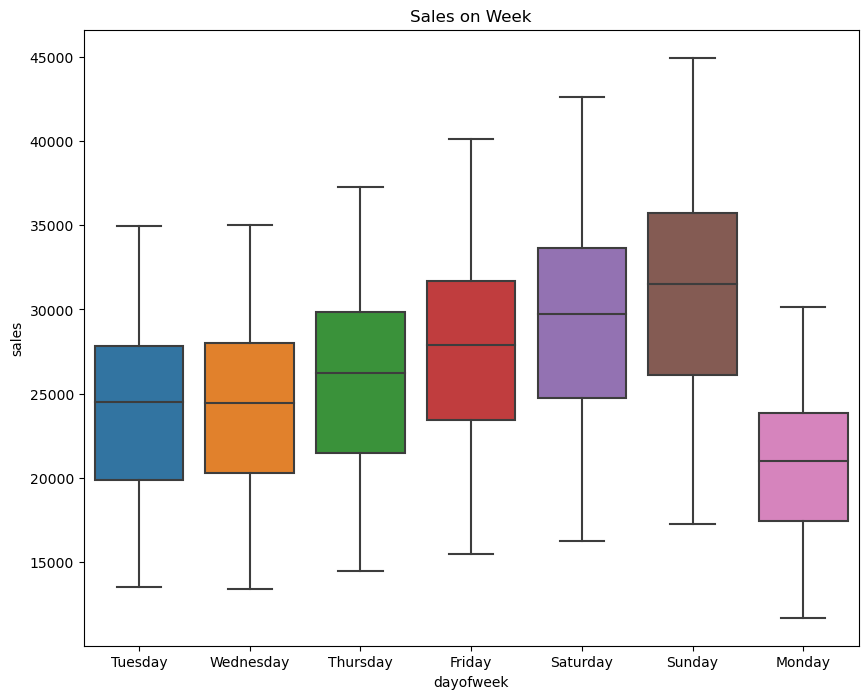

In [60]:
week_day_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}
train_dt_sales_temp = train_dt_sales.copy()
train_dt_sales_temp['dayofweek'] = train_dt_sales_temp['dayofweek'].map(lambda index: week_day_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train_dt_sales_temp, x='dayofweek', y='sales')
ax.set_title('Sales on Week')
plt.show()

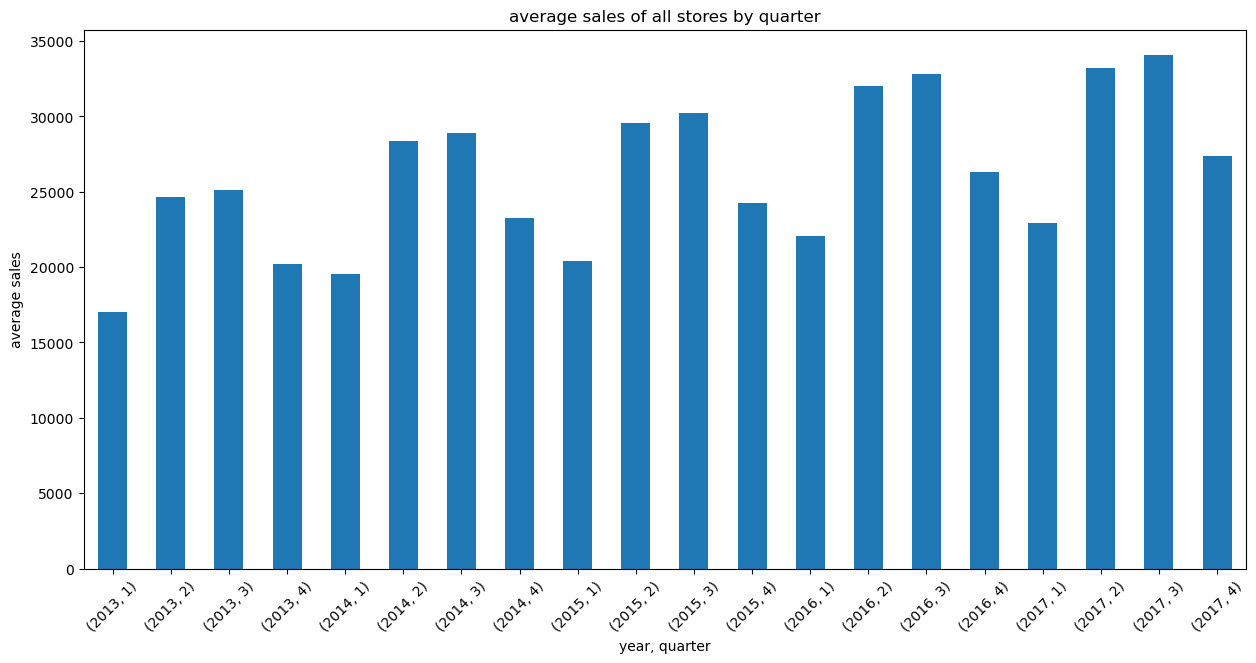

In [61]:
# average sales by all stores across quarters

quarterly_sales = train_dt_sales.groupby(["year", "quarter"]).mean()['sales']
# quarterly_sales.head()

# plotting graph

plt.figure(figsize=(15,7))

quarterly_sales.plot(kind = "bar", label = "average sales")

plt.title("average sales of all stores by quarter")
plt.ylabel("average sales")
plt.xlabel("year, quarter")
plt.xticks(rotation = 45)

plt.show()

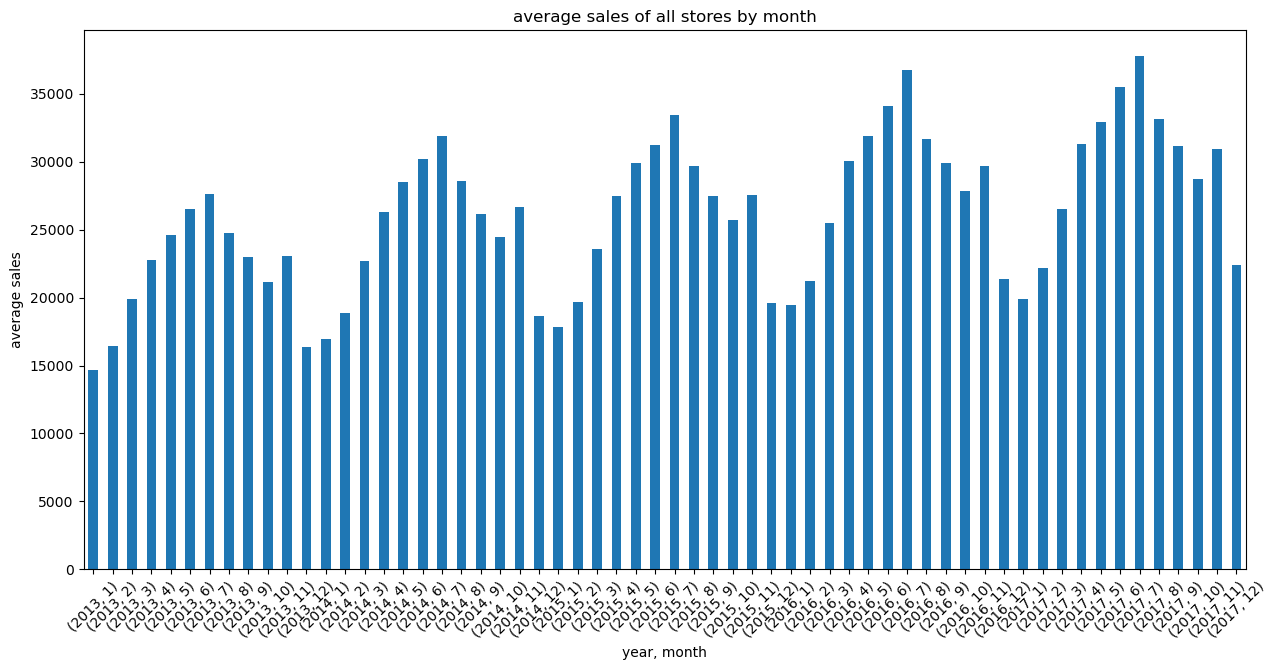

In [62]:
# average sales by all stores, displayed by months

monthly_sales = train_dt_sales.groupby(["year", "month"]).mean()['sales']
# monthly_sales.head()

# plotting graph

plt.figure(figsize = (15,7))

monthly_sales.plot(kind = "bar", label = "average sales")

plt.title("average sales of all stores by month")
plt.ylabel("average sales")
plt.xlabel("year, month")
plt.xticks(rotation = 45)

plt.show()

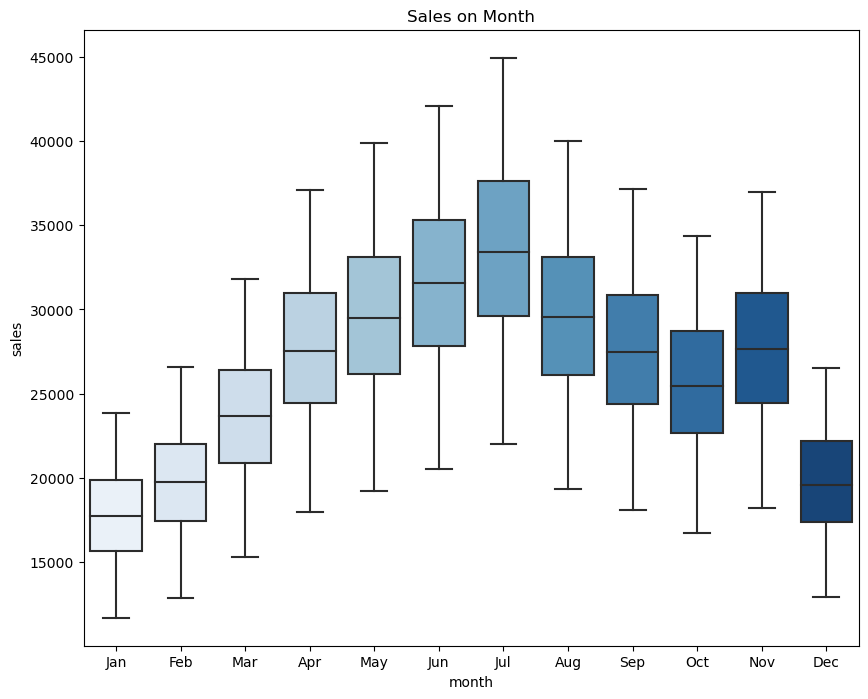

In [63]:
month_map = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}

train_dt_sales_temp['month'] = train_dt_sales_temp['month'].map(lambda index: month_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train_dt_sales_temp, x='month', y='sales', palette='Blues')
ax.set_title('Sales on Month')
plt.show()

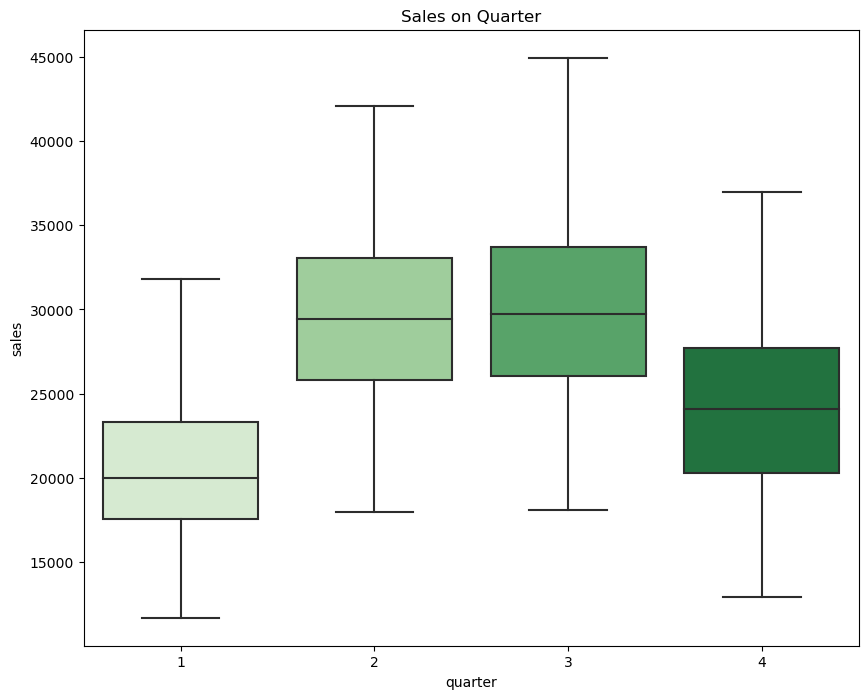

In [64]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train_dt_sales_temp, x='quarter', y='sales', palette='Greens')
ax.set_title('Sales on Quarter')
plt.show()

In [68]:
test.head(2)

,sales
date,
2017-01-01,23709
2017-01-02,15772


In [72]:
#train.drop(['sales_diff'], axis =1, inplace=True)

In [69]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [73]:
train.head()

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2013-01-01,13696,1,1,1,2013,1,1,1
2013-01-02,13678,2,1,1,2013,2,2,1
2013-01-03,14488,3,1,1,2013,3,3,1
2013-01-04,15677,4,1,1,2013,4,4,1
2013-01-05,16237,5,1,1,2013,5,5,1


In [74]:
test.head()

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2017-01-01,23709,6,1,1,2017,1,1,52
2017-01-02,15772,0,1,1,2017,2,2,1
2017-01-03,18650,1,1,1,2017,3,3,1
2017-01-04,18510,2,1,1,2017,4,4,1
2017-01-05,19895,3,1,1,2017,5,5,1


In [75]:
# fit a linear regression model
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

LinearRegression()

In [76]:
#predict on the test(future) data
test['prediction_lr'] = linreg_model.predict(X_test)

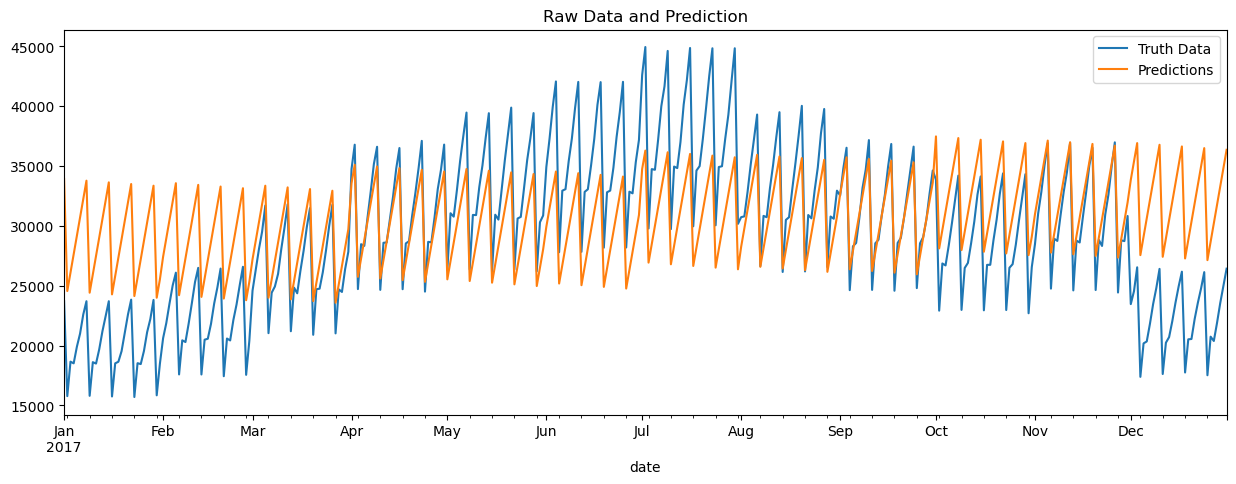

In [77]:
#plot the true sales and predicted sales to understand how the model performed
ax = test[['sales']].plot(figsize=(15, 5))
test['prediction_lr'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [78]:
#metrics to verify the model
linreg_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_lr']))
linreg_mae = mean_absolute_error(test['sales'], test['prediction_lr'])
linreg_r2 = r2_score(test['sales'], test['prediction_lr'])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  5346.264427842602
Linear Regression MAE:  4314.27565354483
Linear Regression R2 Score:  0.3245413312547947


In [79]:
# biuld a random forest model 
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20)

In [80]:
test['prediction_rf'] = rf_model.predict(X_test)

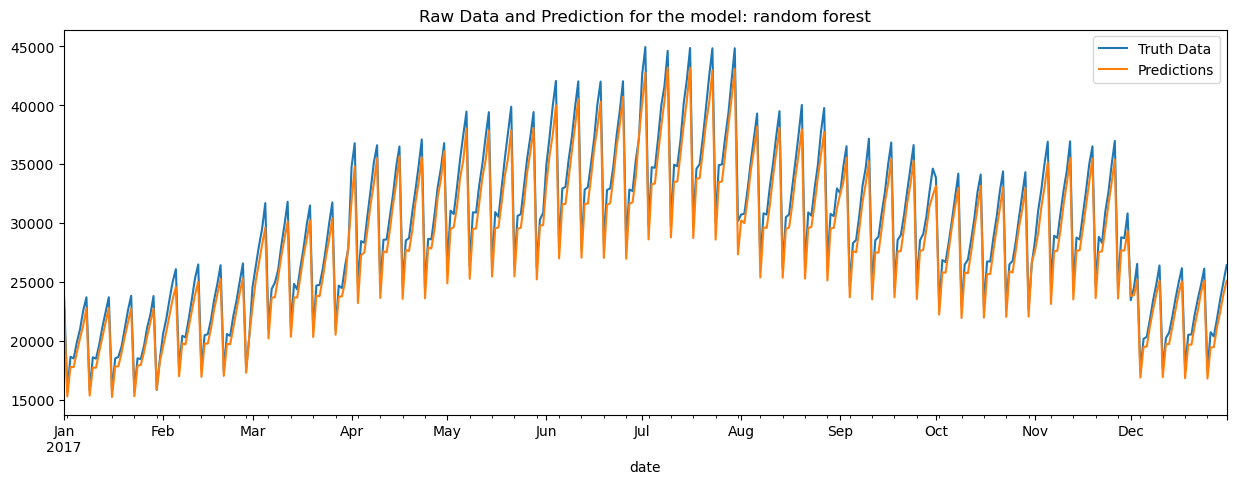

In [81]:
#plot the true and predicted sales
ax = test[['sales']].plot(figsize=(15, 5))
test['prediction_rf'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction for the model: random forest')
plt.show()

In [82]:
#model evaluation metrics
rf_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_rf']))
rf_mae = mean_absolute_error(test['sales'], test['prediction_rf'])
rf_r2 = r2_score(test['sales'], test['prediction_rf'])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

Random Forest RMSE:  1206.1653241981724
Random Forest MAE:  1128.2478356164384
Random Forest R2 Score:  0.9656195476170574


Clearly Random Forest performed way better than linear regression

In [85]:
# xgboost model 

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:25781.08750	validation_1-rmse:29862.51201
[100]	validation_0-rmse:9898.11849	validation_1-rmse:13266.89494
[200]	validation_0-rmse:4182.09546	validation_1-rmse:6504.86421
[300]	validation_0-rmse:2109.32174	validation_1-rmse:3825.64280
[400]	validation_0-rmse:1298.51947	validation_1-rmse:2635.01826
[500]	validation_0-rmse:909.21057	validation_1-rmse:2048.93538


/Users/shaonimukherjee/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:41:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[600]	validation_0-rmse:686.68017	validation_1-rmse:1738.57344
[700]	validation_0-rmse:531.00325	validation_1-rmse:1543.97602
[800]	validation_0-rmse:424.30460	validation_1-rmse:1421.79562
[900]	validation_0-rmse:345.17141	validation_1-rmse:1338.94570
[999]	validation_0-rmse:289.88375	validation_1-rmse:1284.64591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

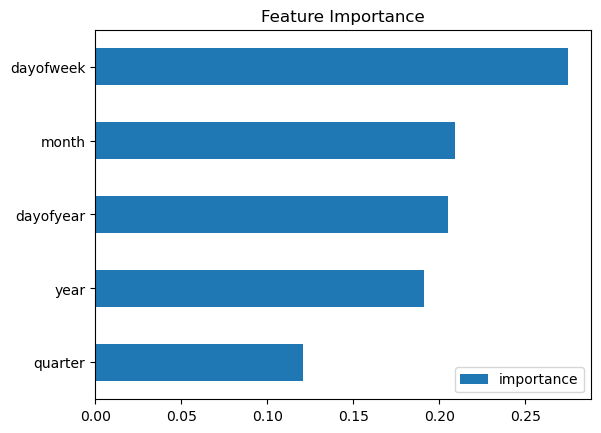

In [86]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

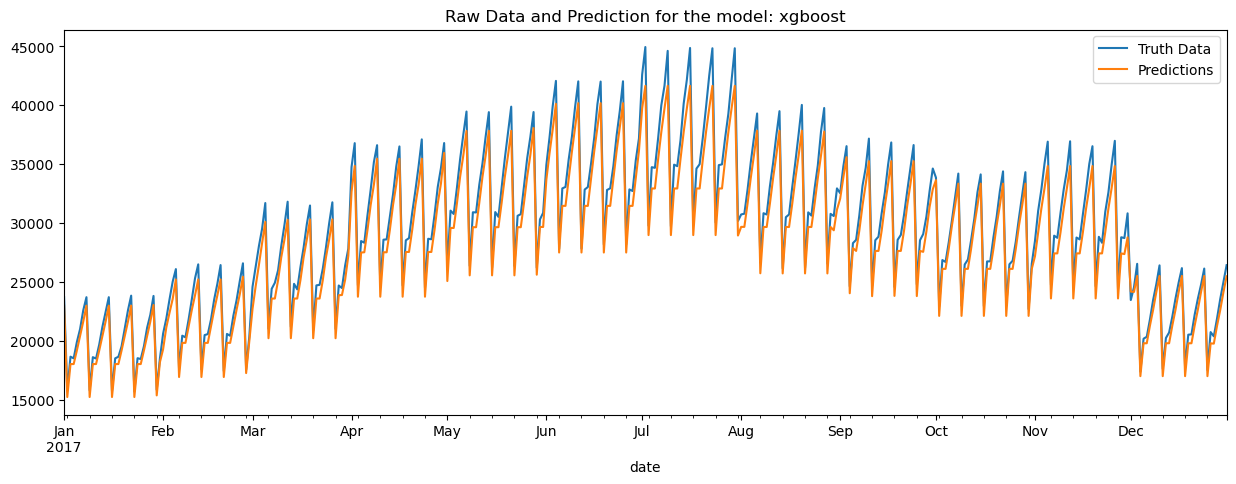

In [87]:
test['prediction_xg'] = reg.predict(X_test)
ax = test[['sales']].plot(figsize=(15, 5))
test['prediction_xg'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction for the model: xgboost')
plt.show()

In [88]:
#model evaluation

xg_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_xg']))
xg_mae = mean_absolute_error(test['sales'], test['prediction_xg'])
xg_r2 = r2_score(test['sales'], test['prediction_xg'])
print('Random Forest RMSE: ', xg_rmse)
print('Random Forest MAE: ', xg_mae)
print('Random Forest R2 Score: ', xg_r2)

Random Forest RMSE:  1284.6459147702851
Random Forest MAE:  1165.0613147474314
Random Forest R2 Score:  0.9609999836165459


XGboost and Random Forest performed almost similar, however the parameters can be tweaked further to improve the model

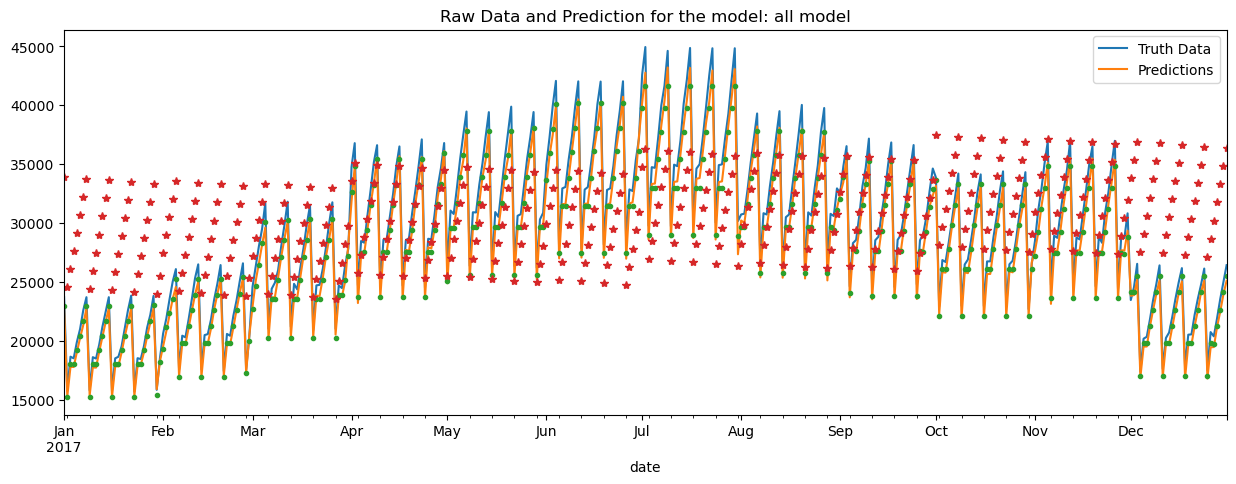

In [91]:
#plot the true and predicted sales
ax = test[['sales']].plot(figsize=(15, 5))
test['prediction_rf'].plot(ax=ax, style='-')
test['prediction_xg'].plot(ax=ax, style='.')
test['prediction_lr'].plot(ax=ax, style='*')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction for the model: all model')
plt.show()

The predictions from the xgboost and rf model are hugging the data most,

In [89]:
test.head()

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_lr,prediction_rf,prediction_xg
date,,,,,,,,,,,
2017-01-01,23709,6,1,1,2017,1,1,52,33909.989333,22813.71,22985.103516
2017-01-02,15772,0,1,1,2017,2,2,1,24552.029563,15283.24,15226.543945
2017-01-03,18650,1,1,1,2017,3,3,1,26088.405834,17786.52,18024.513672
2017-01-04,18510,2,1,1,2017,4,4,1,27624.782104,17776.54,18024.513672
2017-01-05,19895,3,1,1,2017,5,5,1,29161.158374,19039.26,19178.976562


In [92]:
#building a syntetic data to further evaluate the model
to_predict = pd.DataFrame(pd.date_range(start="2018-01-01", end="2019-02-01"), columns=['date'])

In [93]:
to_predict.index = pd.to_datetime(to_predict.date)
to_predict_feature = create_features(to_predict)
to_predict_feature.head()

,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2018-01-01,2018-01-01,0,1,1,2018,1,1,1
2018-01-02,2018-01-02,1,1,1,2018,2,2,1
2018-01-03,2018-01-03,2,1,1,2018,3,3,1
2018-01-04,2018-01-04,3,1,1,2018,4,4,1
2018-01-05,2018-01-05,4,1,1,2018,5,5,1


In [94]:
to_predict_feature = to_predict_feature[FEATURES]

In [98]:
# to_predict_feature.head()

In [96]:
to_predict_feature['prediction'] = reg.predict(to_predict_feature)

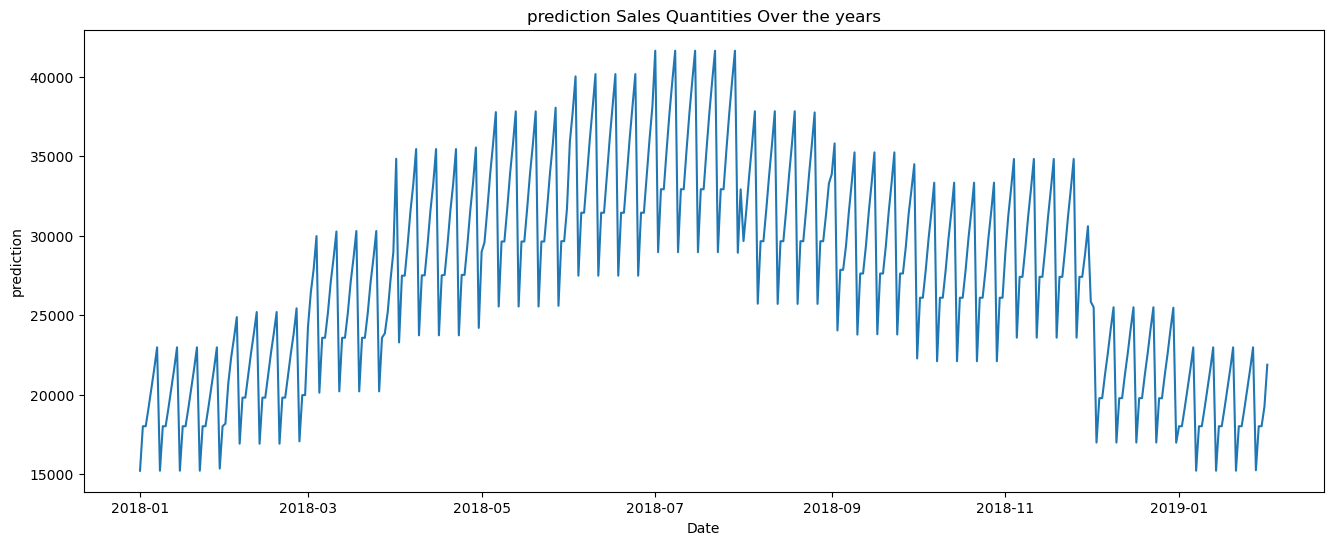

In [99]:
# Set the figure size
plt.figure(figsize=(16, 6))

# Plot the daily sales quantities over time
plt.plot(to_predict_feature.index, to_predict_feature['prediction'])

# Set the title and labels
plt.title('prediction Sales Quantities Over the years')
plt.xlabel('Date')
plt.ylabel('prediction')

# Show the plot
plt.show()

In [100]:
#lets predict the sales on the final test data
test_df.head(2)

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1


In [101]:
test_df.drop(['id','store','item'], axis=1, inplace=True)

In [102]:
test_df.index = pd.to_datetime(test_df.date)
to_predict_test_feature = create_features(test_df)
to_predict_test_feature = to_predict_test_feature[FEATURES]
to_predict_test_feature['prediction'] = reg.predict(to_predict_test_feature)
to_predict_test_feature.head()

,dayofyear,dayofweek,quarter,month,year,prediction
date,,,,,,
2018-01-01,1,0,1,1,2018,15226.543945
2018-01-02,2,1,1,1,2018,18024.513672
2018-01-03,3,2,1,1,2018,18024.513672
2018-01-04,4,3,1,1,2018,19178.976562
2018-01-05,5,4,1,1,2018,20395.173828


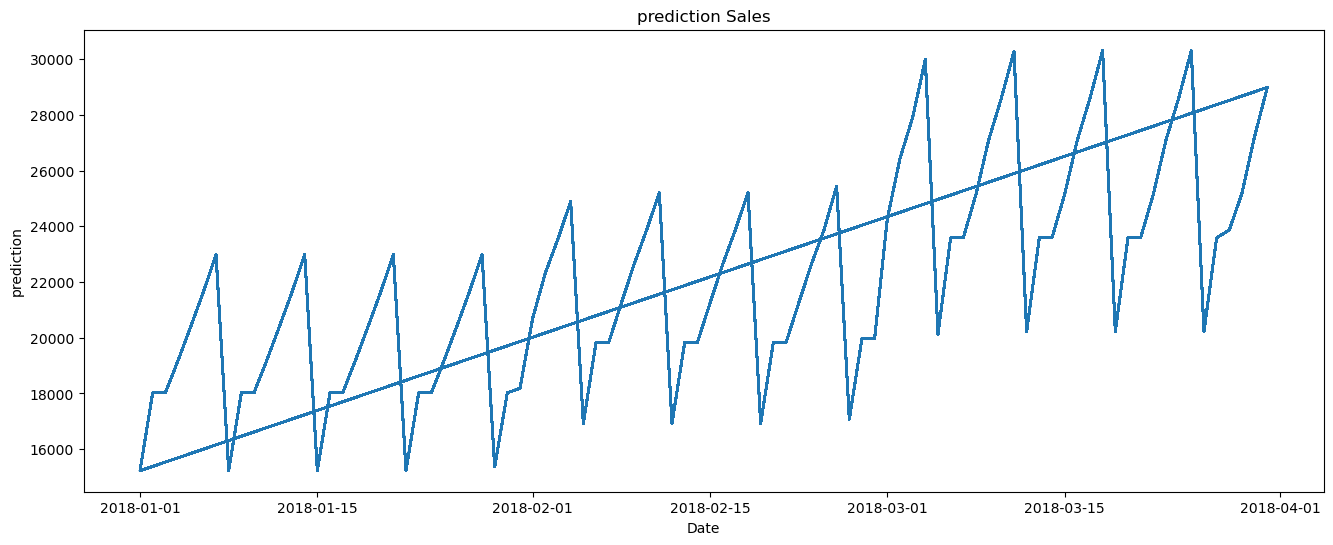

In [103]:
# Set the figure size
plt.figure(figsize=(16, 6))

# Plot the daily sales quantities over time
plt.plot(to_predict_test_feature.index, to_predict_test_feature['prediction'])

# Set the title and labels
plt.title('prediction Sales')
plt.xlabel('Date')
plt.ylabel('prediction')

# Show the plot
plt.show()